## Building a Tiny Knowledge Graph with BERT and Graph Convolutions
This notebook is the source of the code to build and test the graph described in the article


In [1]:
import argparse
import io
import json
import os

from google.cloud import language
import numpy
import six

The following is a simple function for cleaning and extracting sentences.   it was pulled from the web.  not sure of provenance.

In [2]:
# -*- coding: utf-8 -*-
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

# invoking the google entity extractor
to use it you must set up a google cloud account and sign up for the language.googleapis.com service.  You will also need your google credential set  up correctly.  in writing the article and debugging this notebook,  i have spent $26.   so if you have a free google cloud account it won't cost much.



In [3]:

language_client = language.LanguageServiceClient()

def classify(text, verbose=True):
    """Classify the input text into categories. """
    document = language.types.Document(
        content=text,
        type=language.enums.Document.Type.PLAIN_TEXT)
    response = language_client.analyze_entities(document)
    return response

import requests
import wikipedia
def findWikiData(itemurl):
    st = itemurl.find('wiki/')
    item = itemurl[st+5:]
    #print(item)
    s= "https://en.wikipedia.org/w/api.php?action=query&prop=pageprops&titles=%s&format=json"%(item)
    r = requests.get(s)
    rr =r.content.decode("utf-8")
    #print('rr=', rr)
    ans = rr.find('wikibase_item')
    answer = rr[ans+16:]
    e = answer.find('"')
    return item, answer[:e]

This function grabs the instanceOf data (P31) from wikidata.  it returns an empty string if it fails to find anything.  it is basically scraping the json to find the information.  not very elegant.

In [4]:
def getInstanceOfId(wikiID):
    s = 'https://www.wikidata.org/w/api.php?action=wbgetentities&ids=%s&languages=en&format=json'%(wikiID)
    r = requests.get(s)
    rr =r.content.decode("utf-8")
    try:
        j = json.loads(rr)
        k = rr.find('P31')
        if k > 0:
            l = rr[k:].find('"id":')
            if l > 0:
                s = rr[k+l+5:k+l+23]
                t = s.find('}')
                id = s[1:t-1]
                x = id.find('$')
                if x < 0:
                    return id
                else:
                    return id[:x]
            else:
                return ''
        else:
            return ''
    except:
        return ''
    
    

In [5]:
getInstanceOfId('Q678023')

'Q55814'

This is another wikidata scrape to find the name of an object given it's wikidataID

In [6]:
def getNameFromWikiID(wikiID):
    s = 'https://www.wikidata.org/w/api.php?action=wbgetentities&ids=%s&languages=en&format=json'%(wikiID)
    r = requests.get(s)
    if r.status_code == 429:
        time.sleep(8)
        r = requests.get(s)
    rr = r.content.decode("utf-8")
    s = rr.find('"value":')
    rrr= rr[s+8:s+50]
    t = rrr.find('}')
    return rrr[1:t-1]

In [7]:
getNameFromWikiID("Q55814")

'extinction event'

In [8]:
def getDescription(wikiId):
    s = 'https://www.wikidata.org/w/api.php?action=wbgetentities&ids=%s&languages=en&format=json'%(wikiId)
    r = requests.get(s)
    if r.status_code == 429:
      time.sleep(8)
      r = requests.get(s)

    rr =r.content.decode("utf-8")
    i = rr.find("descriptions")
    if i < 0:
        return ''
    else:
        rrr = rr[i:]
        #print(rrr)
        j = rrr.find('"value":')
        if j >0:
            #print(j)
            k = rrr.find("}")
            return(rrr[j+8: k])
        else:
            return ''

In [49]:
getDescription("Q55814")

'"widespread and rapid decrease in the amount of life on earth"'

This function extracts entities from a sentence.   if it is a wikipedia entity  it pulls some wikidata.

In [9]:
def entityExtractorBlock(sents):
    ents = []
    x = classify(sents)
    for ent in x.entities:
        #print('--->', ent.name)
        if ent.metadata['wikipedia_url'] != '' or len(str.split(ent.name))> 1:
            wikipage = ent.metadata['wikipedia_url']
            if wikipage != '':
                name, wikidataId = findWikiData(wikipage)
                ents.append((name, wikidataId, wikipage))

            else:
                wikidataId = "none"
                #print(name, wikidataId, wikipage)
                ents.append((ent.name, wikidataId, wikipage))
        
    return ents

In [10]:
import networkx as nx

The entity extractor creates a list that consists of a list of all of the entities and the last item in the list is the sentence.   

In [11]:
def entityExtractor(sent):
    ents = []
    newents = entityExtractorBlock(sent)
    if newents != []:
        entitem = []
        for x in newents:
            entitem.append({'entity': x})
        entitem.append({'context': sent})
        ents = ents + entitem
    #print(entitem)
    return ents


## add a new file to the graph.
because the articles are named as ArtN to add a new article you need to know the number of articles currently in the graph.  that is art_cnt.

for each sentence in the article it invokes the entity extractor.  with the list of entities it creates the entity nodes for each.   for those entities that are in wikipedia it create a list of "instanceOf" entities (lightgray in color).  it finally creates an article node.   When this is all done it adds the edges as needed. 

In [12]:
def addFile(art_cnt, G, filename):
    items = open('../'+filename+'.txt', 'r').read().replace('\n', '')
    sents = split_into_sentences(items)
    for sent in sents:
        #print(sent)
        ents = entityExtractor(sent)
        all_nodes = []
        nodes = []
        instances = []
        ent_list = []
        for e in ents:
            if e.get('entity') != None:
                ent_list.append(e['entity'][0])
                #this is an entity for this node
                lab = e['entity'][2]
                name = e['entity'][0]
                wikiID = e['entity'][1]
                st = lab.find('wiki/')
                if st <0:
                    item = name
                    #print('Item=', item)
                    G.add_node(item, flavor='entity', url='none', wikiID = 'noID', color = 'lightgreen')
                    #print("just made ", G.node[item])
                    G.nodes[item]['instanceof'] = []
                    G.nodes[item]['subclassof'] = []
                    G.nodes[item]['description'] = ''
                    nodes.append(item)

                else:
                    item = lab[st+5:]
                    #print("item=", item)
                    #wikiID = findWikiData(lab)[1]
                    G.add_node(item, flavor='entity', url=lab, wikiID = wikiID, color = 'lightblue')
                    #print("just smade ", item, G.nodes[item])
                    instID = getInstanceOfId(wikiID)
                    if instID != '':
                        inst_list = [(instID, getNameFromWikiID(instID))]
                        #print([wikiID, (instID, getNameFromWikiID(instID))])
                    else:
                        inst_list = []
                    clas_list = []#isASubclassOf(wikiID)
                    G.nodes[item]['instanceof'] = inst_list
                    instances = instances + inst_list
                    G.nodes[item]['subclassof'] = clas_list        
                    #classes = classes + clas_list
                    G.nodes[item]['description'] = getDescription(wikiID)
                    #print(findWikiData(lab))
                    nodes.append(item)
            if e.get('context') != None:
                # this is a new article
                newart = 'Art'+str(art_cnt)
                G.add_node(newart, flavor='article', source=filename, context=e['context'], color='lightyellow')
                G.nodes[newart]['ent-list'] = ent_list
                #print(newart,G.nodes[newart])
                art_cnt = art_cnt+1
                for z in nodes:
                    G.add_edge(newart,z )
                all_nodes = all_nodes + nodes
                nodes = []
        instance_set = set(instances)
        instances = list(instance_set)
        if instances != []:
            print('instances ====', instances)
        #now make items for these instances
        for i in instances:
            G.add_node(i[1], flavor='entity', url='notknown', wikiID = i[0], color = 'lightgray')
            G.nodes[i[1]]['description'] = getDescription(i[0])
            G.nodes[i[1]]['instanceof'] = []
            G.nodes[i[1]]['subclassof'] = []
        #now add edges from the instance to the new entity
        all_nodes_set = set(all_nodes)
        all_nodes =  list(all_nodes_set)
        for n in all_nodes:
            if G.nodes[n]['instanceof'] != []:
                elist = G.nodes[n]['instanceof']
                for e in elist:
                    G.add_edge(n, e[1])
    print(art_cnt)
    return art_cnt

## build the graph from the documents.
We are skiping these steps because it is easier to load the graph from the stored graph.  saves lots of time.   If you have your own set of documents you can uncoment this run it.

The next line reads the graph file from the saved copy.  

In [13]:
#nx.write_gpickle(G, 'phy_plus_geo_singlesent')
G = nx.read_gpickle('phy_plus_geo_singlesent')

The following will plot the graph.  do not try to plot the entire graph.  too big! 
but we will use it for subgraphs.

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
def showGraph(sg):
    options = {
        'node_size': 3000,
        'font_weight': 'bold',
         'edgecolors':'black',
        'width': 2,
    }
    labels = {}
    color = []
    for n in sg.nodes:
        d =sg.nodes[n]
        #print(d)
        color.append(d['color'])
        labels[n]=n
    
    #print(color)
        #print(sg.nodes[x]['url'])
        #labels[]
        
    plt.figure(3,figsize=(15,15)) 

    nx.draw(sg, labels = labels, node_color = color, **options)   

utilities to inspect graph nodes.

In [50]:
def showArticle(graph, name):
    print(name, graph.nodes[name]['context'])
    print('all edges from this node are:')
    for x in graph.edges():
        if x[1] == name:
            print(x, graph.nodes[x[0]]['url'], graph.nodes[x[0]]['wikiID'])
            

def showEntity(graph, name):
    instances = []
    classes = []
    print(name,' wikiID=', graph.nodes[name]['wikiID'], 'wikipedia url =', graph.nodes[name]['url'])
    print(graph.nodes[name]['description'])
    inst = graph.nodes[name]['instanceof'] 
    if inst != []:
        instances = instances +inst
        ilist = [i[1] for i in inst]
        print('is an instance of ', ilist)



In [43]:
showEntity(G, 'Cretaceous')

Cretaceous  wikiID= Q44626 wikipedia url = https://en.wikipedia.org/wiki/Cretaceous
"third and last period of the Mesozoic Era"
is an instance of  ['geological period']


In [44]:
showEntity(G, 'geological period')

geological period  wikiID= Q392928 wikipedia url = notknown
"subdivision of geological time; shorter than an era and longer than an epoch"


The scorekey function divides the world into 7 categories.   notice relativity is in all the physics categories ... because it is.

In [ ]:
climate = set(['climate', 'climate-change'])
extinction =  set(['late-devonian', 'extinction', "climate-extinctions"])
human_extinct = set(['human-extinction'])
relativity = set(['relativity'])
blackholes = set(['relativity','blackhole','blackhole-neutron', 'gravitational-wave'])
qgrav = set(['relativity', 'quantum-gravity', 'quantum-grav3', 'string-theory'])
cosmo = set(['relativity', 'cosmology'])

def scorekey(key1, key2):
    if key1 in climate and key2 in climate:
        return 1
    if key1 in extinction and key2 in extinction:
        return 1
    if key1 in human_extinct and key2 in human_extinct:
        return 1
    if key1 in relativity and key2 in relativity:
        return 1
    if key1 in blackholes and key2 in blackholes:
        return 1
    if key1 in qgrav and key2 in qgrav:
        return 1
    if key1 in cosmo and key2 in cosmo:
        return 1
    return 0

Some book keeping

In [20]:
instances = []
classes = []
lines = []
ent_cnt = 0
for nd in G.nodes:
    #print(G.nodes[nd])
    node = G.nodes[nd]
    if node['flavor'] == 'entity':
        ent_cnt +=1
        inst = node['instanceof']
        instances = instances + inst
        clas = node['subclassof']
        classes = classes + clas
    elif node['flavor'] == 'article':
        #print('doing art ',nd, node)
        lines.append([node['context'], nd])
instanceSet = set(instances)
instances = list(instanceSet)
classSet = set(classes)
classes = list(classSet)
print('instances =', len(instances))
print("---------------")
print('classes =', len(classes))
print('lines =', len(lines))
print('entities = ', ent_cnt)

instances = 90
---------------
classes = 0
lines = 427
entities =  691


In [22]:
sentences = [lines[i][0] for i in range(len(lines))]

In [23]:
keys = [lines[i][1] for i in range(len(lines))]

## Create the BERT embedding
and the matrix mar which stores the normalized imbedding vectors.

In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [25]:
sentence_embeddings = sbert_model.encode(sentences)
import numpy as np
mar = np.zeros((len(sentences), 768))
for i in range(len(sentences)):
    x = np.linalg.norm(sentence_embeddings[i])
    mar[i] = sentence_embeddings[i]/x

In [27]:
def find_in_keys(nodeid):
    for i in range(len(keys)):
        if nodeid == keys[i]:
            return i
    return -1


## The function find_best
this function takes a sentence and look for the k closest matches based on proximity to the BERT model vectors stored in mar.   This uses dotproduct of normalized vectors which is the same as cosine distance.

In [29]:
def find_best(k, abstract, show=True):
    v = sbert_model.encode([abstract])[0]
    v0 = v/np.linalg.norm(v)
    norms = []
    for i in range(mar.shape[0]):
        norms.append([np.dot(v0,mar[i]), i])
    norms.sort(reverse=True)
    if show:
        print('top ',k, ' related nodes' )
    scor = 0.0
    #print(norms[0][1])
    nodename = keys[norms[0][1]]
    category =  G.nodes[nodename]['source']
    for i in range(k):
        node = keys[norms[i][1]]
        if scorekey(G.nodes[node]['source'],category) == 1:
            scor +=1.0
        if show:
            print(node)
            print(sentences[norms[i][1]])
    scor = scor/k
    return scor, norms[0:k]

## find_best3
is the same as find_best but we remove candidates that are not in the same connected component.  note: k must be less than 40.   

In [61]:
def find_best3(k, abstract, show=True):
    v = sbert_model.encode([abstract])[0]
    v0 = v/np.linalg.norm(v)
    norms = []
    for i in range(mar.shape[0]):
        norms.append([np.dot(v0,mar[i]), i])
    norms.sort(reverse=True)
    nodename = keys[norms[0][1]]
    newlist = []
    nopath = 0
    for i in range(40):
        #print(norms[i])
        x = norms[i][1]
        try:
            path = nx.shortest_path(G, nodename, 'Art'+str(x))
            #print(path)
            newlist.append(norms[i])
        except:
            nopath += 1
    norms = newlist
    ln = len(norms)
    if show:
        print('top ',k, ' related nodes' )
        if ln < k:
            print('but only found ', ln)
    scor = 0.0
    #print(norms[0][1])
    nodename = keys[norms[0][1]]
    category =  G.nodes[nodename]['source']
    for i in range(min(ln, k)):
        node = keys[norms[i][1]]
        if scorekey(G.nodes[node]['source'],category) == 1:
            scor +=1.0
        if show:
            print(node)
            print(sentences[norms[i][1]])
    scor = scor/min(ln, k)
    return scor, min(ln, k)

In [62]:
find_best3(5, 'Black Holes are hide behind Event horizons.')

top  5  related nodes
Art0
The Theory of General Relativity demonstrates that Black Holes are hidden by event horizons.
Art61
Finkelstein's solution extended the Schwarzschild solution for the future of observers falling into a black hole.
Art76
Such "black neutron stars" were not thought possible and will mean ideas for how neutron stars and black holes form will need to be rethought.
Art34
In many ways, a black hole acts like an ideal black body, as it reflects no light.
Art108
â€œSo, the particle would actually smear across space as it falls, which would violate the equivalence principle".


(1.0, 5)

## find_best2
the function find_best2 is more complicated.  

The function findClue extracts entities from the sentence and then looks for the closest match in all of the articles among those that have the same entities.  if there are more than 2 with the max number of matches we just give up and return [].   

To compute the convolutions we need to find all the neighbors of each node.  two nodes are neighbors if they share an entity node.   note that in the computation of findNeighbors we exclude two super nodes "albert_einstein" and "earth".   these node make too many nodes neighbors. 

ComputeMar2 is the function that computes the convolution matrix mar2.   

Function find_best_wl2 is a version of find_best that uses a article nodeID rather than a document to rank near nodes (based on mar2)  it is a utility used in find_best2

Function find_best2 looks for clues.  there are either 0, 1 or 2 clues.   if there are 0 clues we use find_best(1 ...) to give us a guess.    if there are 1 or 2 clues we use them in find_best_wl2 to complete the list.  (in the case of 2 clues we use the first clue to generate the first two replies and the second clue to get the rest.  



In [70]:
def findClue(G, sent, show = True):
    cls = entityExtractorBlock(sent)
    clsent = [x[0] for x in cls]
    if show:
        print(clsent)
    arts = []
    for x in cls:
        item = x[0]
        for edg in G.edges():
            #print(edg)
            if edg[0] == item and G.nodes[edg[1]]['flavor'] == 'article':
                arts.append(edg[1])
    artset = set(arts)
    artnames = list(artset)
    factoredartnames = []
    for art in artnames:
        #context = G.nodes[art]['context']
        #print('context=',context)
        cls1ent = G.nodes[art]['ent-list']
        #cls1ent = [x[0] for x in cls1]
        cls1int = set(clsent).intersection(set(cls1ent))
        if cls1int != set():
            factoredartnames.append((art, len(cls1int)))
        artnames = [x[0] for x in factoredartnames]
    #if show:
    #    print('artnames=',artnames)
    dic = {}
    for x in artnames:
        dic[x] = 0
    for x in factoredartnames:
        dic[x[0]] = x[1]
    #print('DIC =',dic)
    bmax = 0
    bestmax = ''
    for x in artnames:
        if dic[x] > bmax:
            bmax = dic[x]
            #print(x)
            bestmax = x
    count_ties = 0
    tie_list = []
    for x in artnames:
        if dic[x] == bmax:
            count_ties += 1
            tie_list.append(x)
    if show:
        print(count_ties, 'nodes out of',len(artnames), 'matched the max value of ', bmax)
    if count_ties >  0.5*len(artnames) and len(artnames)> 2:
        return  []
    return tie_list
   

def findNeighbors(g, art):
    n = g.nodes[art]
    #print(n)
    features = []
    neighbors = []
    for x in g.edges:
        if x[1] == art:
            #print('found art in ',x)
            p = x[0]
            features.append(p)
            if p != 'Albert_Einstein' and p != 'Earth':
                for y in g.edges:
                    if y[0] == p:
                        if y[1] != art:
                            #print(y[1][0:3])
                            if y[1][0:3] != 'Art':
                                features.append(y[1])
                            else:
                                neighbors.append(y[1])
    return neighbors, features

mar2 = np.zeros((len(sentences), 768))
def computeMar2(G, mar, lambd):
    num_zero_neighbors = 0
    tot_neighbors = 0
    num_arts = 0
    for art in G.nodes():
        if G.nodes[art]['flavor'] == 'article':
            num_arts += 1.0
            neighbors, features =  findNeighbors(G, art)
            v = np.zeros((768))
            c = 0.0
            if len(neighbors) == 0:
                num_zero_neighbors +=1
            tot_neighbors += len(neighbors)
            if len(neighbors) > 0:
                for x in neighbors:
                    loc = find_in_keys(x)
                    v = v + mar[loc]
                    c = c+1.0
                v = v/c
                z = lambd*mar[find_in_keys(art)] + (1.0-lambd)*v
                z = z/np.linalg.norm(z)
                mar2[find_in_keys(art)] = z
            else:
                mar2[find_in_keys(art)] = mar[find_in_keys(art)]

    return num_zero_neighbors, tot_neighbors/num_arts


def find_best2(k, abstract, show=True):
    cls = findClue(G, abstract, show)
    #print('clues are =', cls)
    if cls != []:
        best = cls[0]
    else:
        _, x = find_best(1, abstract, show=False)
        best = keys[x[0][1]]
    if(len(cls)> 1):
        scora, normsa = find_best_wl2(2, cls[0], show)
        scorb, normsb = find_best_wl2(k-2, cls[1], show)
        scor = (2*scora+(k-2)*scorb)/k
        norms = normsa+normsb
    else:
        scor, norms = find_best_wl2(k, best, show)
    if show:
        print('score =', scor)
    return scor, norms


def find_best_wl2(k, nodeid, show=True):
    #print(nodeid)
    v0 = mar2[find_in_keys(nodeid)]
    norms = []
    for i in range(mar2.shape[0]):
        norms.append([np.dot(v0,mar2[i]), i])
    norms.sort(reverse=True)
    score = 0.0
    #if show:
    #    print('top ',k, ' related nodes' )
    scor = 0.0
    nodename = keys[norms[0][1]]
    category =  G.nodes[nodename]['source']
    for i in range(k):
        node = keys[norms[i][1]]
        sent = sentences[norms[i][1]]
        #print('node = ', node)
        nodea = node
        if scorekey(G.nodes[nodea]['source'],category) == 1:
            scor +=1.0
        if show:
            print(node)
            print(sent)
    scor = scor/k
    return scor, norms[0:k]
            
def showRelated(G,art):
    print( G.nodes[art]['context'])
    neighbors, features =  findNeighbors(G, art)
    n = set(neighbors)
    neighbors = list(n)
    print(neighbors)
    for x in neighbors:
        print( G.nodes[x]['context'])
        v0 = mar[find_in_keys(art)]
        v1 = mar[find_in_keys(x)]
        print(" dot prod =", np.dot(v0,v1))
    print(features)



## Compute mar2
the embedding vectors for the convolution of the BERT embedding

In [71]:
computeMar2(G, mar, 0.8)

(140, 5.02576112412178)

find_best2_5 is the same as find_best2 but we eliminate all candidates that are not connected to the top choice.   This is like find_best3 above, and k must be less than 40.

In [64]:
def find_best2_5(k, text, show = True):
    _, norms = find_best2(40, text, show = False)
    nodename = keys[norms[0][1]]
    newlist = []
    nopath = 0
    for i in range(40):
        #print(norms[i])
        x = norms[i][1]
        try:
            path = nx.shortest_path(G, nodename, 'Art'+str(x))
            #print(path)
            newlist.append(norms[i])
        except:
            nopath += 1
    norms = newlist
    ln = len(norms)

    if show:
        print('top ',k, ' related nodes' )
    scor = 0.0
    #print(norms[0][1])
    nodename = keys[norms[0][1]]
    category =  G.nodes[nodename]['source']
    for i in range(min(k,ln)):
        node = keys[norms[i][1]]
        if scorekey(G.nodes[node]['source'],category) == 1:
            scor +=1.0
        if show:
            print(node)
            print(sentences[norms[i][1]])
            
    scor = scor/min(ln, k)
    return scor, min(ln,k)

## Examples

In [38]:
find_best2(4, 'Black Holes are hidden by an Event horizon.')

['Black_hole', 'Event horizon']
6 nodes out of 6 matched the max value of  1
Art0
The Theory of General Relativity demonstrates that Black Holes are hidden by event horizons.
Art9
This solution laid the groundwork for the description of the final stages of gravitational collapse, and the objects known today as Black Holes.
Art35
Moreover, quantum field theory in curved spacetime predicts that event horizons emit Hawking radiation, with the same spectrum as a black body of a temperature inversely proportional to its mass.
Art61
Finkelstein's solution extended the Schwarzschild solution for the future of observers falling into a black hole.
score = 1.0


(1.0,
 [[1.0, 0],
  [0.8253896427602846, 9],
  [0.8175291113883197, 35],
  [0.813318770065547, 61]])

In [114]:
find_best(4, 'What is dark energy?')

top  4  related nodes
Art6
The Einstein field equations are nonlinear and very difficult to solve.
Art0
The Theory of General Relativity demonstrates that Black Holes are hidden by event horizons.
Art103
But, given that the two theories are so different, it is not clear that the idea still holds at the quantum level.
Art125
If one attempts to treat gravity as simply another quantum field, the resulting theory is not renormalizable.


(1.0,
 [[0.6555333065408873, 6],
  [0.6469091193111116, 0],
  [0.629927947038547, 103],
  [0.6216816364341731, 125]])

In [77]:
find_best2(4, 'What is dark energy?')

['dark energy']
2 nodes out of 2 matched the max value of  1
Art210
On 1 December 2014, at the Planck 2014 meeting in Ferrara, Italy, astronomers reported that the universe is 13 billion years old and is composed of 5% atomic matter, 26% dark matter and 68% dark energy.
Art52
As of December 2018, eleven gravitational wave events have been observed that originated from ten merging black holes (along with one binary neutron star merger).
Art189
Modern physical cosmology is dominated by the Big Bang theory, which attempts to bring together observational astronomy and particle physics; more specifically, a standard parameterization of the Big Bang with dark matter and dark energy, known as the Lambda-CDM model.
Art186
Cosmology is a branch of astronomy concerned with the studies of the origin and evolution of the universe, from the Big Bang to today and on into the future.
score = 0.75


(0.75, [[1.0, 189], [0.9134191095796336, 186]])

In [115]:
find_best(4, 'unification of general relativity and quantum theory is  supersymmetry known as supergravity')

top  4  related nodes
Art131
In what is called the second superstring revolution, it was conjectured that both string theory and a unification of general relativity and supersymmetry known as supergravity form part of a hypothesized eleven-dimensional model known as M-theory, which would constitute a uniquely defined and consistent theory of quantum gravity.
Art128
The central idea of string theory is to replace the classical concept of a point particle in quantum field theory, with a quantum theory of one-dimensional extended objects: string theory.
Art105
To this they added the principle of quantum superposition, which holds that particles can be smeared into more than one state at once.
Art112
Instead, Zych imagined kind of quantum conjoined twins, built from the quantum superposition of two different energy states - and therefore two superposed masses.


(1.0,
 [[0.8305973333011722, 131],
  [0.826438082502694, 128],
  [0.8065965972368991, 105],
  [0.8039374384164013, 112]])

In [116]:
find_best2(4, 'unification of general relativity and quantum theory is  supersymmetry known as supergravity')

['general relativity', 'quantum theory']
13 nodes out of 13 matched the max value of  1
Art131
In what is called the second superstring revolution, it was conjectured that both string theory and a unification of general relativity and supersymmetry known as supergravity form part of a hypothesized eleven-dimensional model known as M-theory, which would constitute a uniquely defined and consistent theory of quantum gravity.
Art119
How can the theory of quantum mechanics be merged with the theory of general relativity  gravitational force and remain correct at microscopic length scales?
Art128
The central idea of string theory is to replace the classical concept of a point particle in quantum field theory, with a quantum theory of one-dimensional extended objects: string theory.
Art120
What verifiable predictions does any theory of quantum gravity make?
score = 1.0


(1.0,
 [[1.0, 131],
  [0.8823622585368085, 119],
  [0.879557346861881, 128],
  [0.8670221364630675, 120]])

In [117]:
find_best(4, 'What is M-theory and what does it have to do with string theory and supersymmetry theory')

top  4  related nodes
Art128
The central idea of string theory is to replace the classical concept of a point particle in quantum field theory, with a quantum theory of one-dimensional extended objects: string theory.
Art131
In what is called the second superstring revolution, it was conjectured that both string theory and a unification of general relativity and supersymmetry known as supergravity form part of a hypothesized eleven-dimensional model known as M-theory, which would constitute a uniquely defined and consistent theory of quantum gravity.
Art120
What verifiable predictions does any theory of quantum gravity make?
Art119
How can the theory of quantum mechanics be merged with the theory of general relativity  gravitational force and remain correct at microscopic length scales?


(1.0,
 [[0.8063261405810636, 128],
  [0.7838317084143955, 131],
  [0.7744984495336569, 120],
  [0.7575365019589617, 119]])

In [118]:
find_best2(4, 'What is M-theory and what does it have to do with string theory and supersymmetry theory')

['string theory', 'supersymmetry theory']
12 nodes out of 12 matched the max value of  1
Art128
The central idea of string theory is to replace the classical concept of a point particle in quantum field theory, with a quantum theory of one-dimensional extended objects: string theory.
Art131
In what is called the second superstring revolution, it was conjectured that both string theory and a unification of general relativity and supersymmetry known as supergravity form part of a hypothesized eleven-dimensional model known as M-theory, which would constitute a uniquely defined and consistent theory of quantum gravity.
Art107
This prediction allowed the pair to propose tests that would tease out the quantum behaviour of gravitational acceleration.
Art181
One essential quality of string theory is known as supersymmetry, a mathematical property that requires every known particle species to have a partner particle species, called a superpartner.
score = 1.0


(1.0,
 [[1.0, 128],
  [0.879557346861881, 131],
  [0.8511244426214744, 107],
  [0.8446809448255247, 181]])

In [119]:
find_best(4, 'Can a neutron star and a black hole merge')

top  4  related nodes
Art133
Gravitational waves have been detected from the collision and merging of two neutron stars.
Art153
The animation below illustrates how gravitational waves are emitted by two neutron stars as they orbit each other and then coalesce (credit: NASA/Goddard Space Flight Center).
Art48
If there are other stars orbiting a black hole, their orbits can be used to determine the black hole's mass and location.
Art43
By absorbing other stars and merging with other black holes, supermassive black holes of millions of solar masses  may form.


(1.0,
 [[0.8409578509713314, 133],
  [0.8211693463514087, 153],
  [0.810935473946456, 48],
  [0.8048706083552655, 43]])

In [120]:
find_best2(4, 'Can a neutron star and a black hole merge')

['neutron star', 'black hole merge']
2 nodes out of 2 matched the max value of  1
Art56
They were partly correct: a white dwarf slightly more massive than the Chandrasekhar limit will collapse into a neutron star, which is itself stable.
Art90
Current theories suggest that the gravitational force would overcome the degeneracy pressure if the Neutron Star were much larger than two solar masses - and cause it to collapse into a Black Hole.
Art89
A neutron star also has powerful gravity pulling it together, but a force between the neutrons, caused by a Quantum Mechanical effect known as degeneracy pressure, pushes the particles apart, counteracting the gravitational force.
Art152
Other waves are predicted to be caused by the rotation of neutron stars that are not perfect spheres, and possibly even the remnants of gravitational radiation created by the Big Bang.
score = 1.0


(1.0, [[1.0, 89], [0.884448889329471, 152]])

In [121]:
find_best(4, 'How old is the universe and how much of the universe is dark matter and how much is dark energy')

top  4  related nodes
Art36
This temperature is on the order of billionths of a kelvin for black holes of stellar mass, making it essentially impossible to observe.
Art87
If it is a very large star, it collapses to form a black hole, an object with such strong gravitational force that not even light can escape its grasp.
Art41
Black holes of stellar mass are expected to form when very massive stars collapse at the end of their life cycle.
Art0
The Theory of General Relativity demonstrates that Black Holes are hidden by event horizons.


(1.0,
 [[0.6923039160483202, 36],
  [0.6576848209918602, 87],
  [0.6572677173226659, 41],
  [0.6550144063023944, 0]])

In [122]:
find_best2(4, 'How old is the universe and how much of the universe is dark matter and how much is dark energy')

['dark energy', 'dark matter']
2 nodes out of 2 matched the max value of  2
Art210
On 1 December 2014, at the Planck 2014 meeting in Ferrara, Italy, astronomers reported that the universe is 13 billion years old and is composed of 5% atomic matter, 26% dark matter and 68% dark energy.
Art52
As of December 2018, eleven gravitational wave events have been observed that originated from ten merging black holes (along with one binary neutron star merger).
Art189
Modern physical cosmology is dominated by the Big Bang theory, which attempts to bring together observational astronomy and particle physics; more specifically, a standard parameterization of the Big Bang with dark matter and dark energy, known as the Lambda-CDM model.
Art186
Cosmology is a branch of astronomy concerned with the studies of the origin and evolution of the universe, from the Big Bang to today and on into the future.
score = 0.75


(0.75, [[1.0, 189], [0.9134191095796336, 186]])

In [123]:
find_best(4, 'what is dark energy?')

top  4  related nodes
Art6
The Einstein field equations are nonlinear and very difficult to solve.
Art0
The Theory of General Relativity demonstrates that Black Holes are hidden by event horizons.
Art103
But, given that the two theories are so different, it is not clear that the idea still holds at the quantum level.
Art125
If one attempts to treat gravity as simply another quantum field, the resulting theory is not renormalizable.


(1.0,
 [[0.6555333065408873, 6],
  [0.6469091193111116, 0],
  [0.629927947038547, 103],
  [0.6216816364341731, 125]])

In [124]:
find_best2(4, 'what is dark energy?')

['dark energy']
2 nodes out of 2 matched the max value of  1
Art210
On 1 December 2014, at the Planck 2014 meeting in Ferrara, Italy, astronomers reported that the universe is 13 billion years old and is composed of 5% atomic matter, 26% dark matter and 68% dark energy.
Art52
As of December 2018, eleven gravitational wave events have been observed that originated from ten merging black holes (along with one binary neutron star merger).
Art189
Modern physical cosmology is dominated by the Big Bang theory, which attempts to bring together observational astronomy and particle physics; more specifically, a standard parameterization of the Big Bang with dark matter and dark energy, known as the Lambda-CDM model.
Art186
Cosmology is a branch of astronomy concerned with the studies of the origin and evolution of the universe, from the Big Bang to today and on into the future.
score = 0.75


(0.75, [[1.0, 189], [0.9134191095796336, 186]])

In [125]:
find_best(4,'mass extinctions were caused by volcanic action and astroid impact.')

top  4  related nodes
Art321
Changes oceanic chemistry and circulation, End-Triassic extinction: Volcanic activity End-Cretaceous extinction: Asteroid impact Volcanic activity Climate change Changes in atmospheric and oceanic chemistry.
Art406
It is believed that the Cretaceous mass extinction was caused by meteorites that fell to the earth causing a dust cloud.
Art271
Detecting either of the long-lived radioisotopes Sm146 or Pu244 in one or more end-Devonian extinction strata would confirm a supernova origin, point to the core-collapse explosion of a massive star, and probe supernova nucleosynthesis.
Art270
We therefore propose that the end-Devonian extinctions were triggered by supernova explosions at 20â€‰pc, somewhat beyond the "kill distance" that would have precipitated a full mass extinction.


(0.75,
 [[0.8456810400096684, 321],
  [0.8168135285733771, 406],
  [0.8075490385509255, 271],
  [0.7991286224259633, 270]])

In [126]:
find_best2(4,'mass extinctions were caused by volcanic action and astroid impact.')

[]
0 nodes out of 0 matched the max value of  0
Art321
Changes oceanic chemistry and circulation, End-Triassic extinction: Volcanic activity End-Cretaceous extinction: Asteroid impact Volcanic activity Climate change Changes in atmospheric and oceanic chemistry.
Art320
Here are some hypothesized causes for each of Earth's biggest mass extinctions End-Ordovician exinction Beginning of glacial cycles on Earth, and corresponding changes in sea level Changes in atmospheric and oceanic chemistry relating to the rise of the Appalachian mountains, End-Devonian extinction: Climate change, possibly linked to the diversification of land pla Decrease in oxygen levels in the deep ocean, End-Permian extinction: Volcanic activity Climate change Decrease in oxygen levels in the deep ocean Changes in atmospheric chemistry.
Art343
The most likely cause of the Cretaceous mass extinction was an extraterrestrial impact in the Yucatan of modern-day Mexico, a massive volcanic eruption in the Deccan Province

(0.5,
 [[1.0, 321],
  [0.8632037399145038, 320],
  [0.8432760493114796, 343],
  [0.8347331615004198, 406]])

In [127]:
find_best(4,'What are the names of the extinction events and what is the most recent.')

top  4  related nodes
Art312
Holocene extinction: Currently ongoing.
Art346
But whether this constitutes a sixth mass extinction depends on whether today's extinction rate is greater than the "normal" or "background" rate that occurs between mass extinctions.
Art301
The event formerly called the Cretaceous-Tertiary or K-T extinction or K-T boundary is now officially named the Cretaceous-Paleogene (or K-Pg)extinction event.
Art356
If this doesn't sound like much, it's important to remember extinction is always preceded by a loss in population abundance and shrinking distributions.


(0.5,
 [[0.7428157150250396, 312],
  [0.7010667565881309, 346],
  [0.6819275401046124, 301],
  [0.6647226924526317, 356]])

In [128]:
find_best2(4,'What are the names of the extinction events and what is the most recent.')

['extinction events']
8 nodes out of 8 matched the max value of  1
Art312
Holocene extinction: Currently ongoing.
Art401
Previous mass extinctions have occurred towards the ends of the Ordovician, Devonian, Permian, Triassic and Cretaceous eras (Mader, 2008).
Art290
Late Devonian extinction: 375-360 million years ago near the Devonian-Carboniferous transition.
Art273
The Late Devonian biodiversity crisis is characterized by a protracted decline in speciation rate occurring over millions of years (1, 2), punctuated by an extinction pulse (Kellwasser event) followed 10 My later by a more moderate extinction (Hangenberg event) around the Devonian-Carboniferous boundary (DCB) 359 My ago.
score = 0.75


(0.75,
 [[1.0000000016953736, 312],
  [0.7285234974026414, 401],
  [0.723620772975837, 290],
  [0.7195094375306612, 273]])

In [88]:
find_best(4, 'is there a sixth mass extinction?')

top  4  related nodes
Art344
Is today's biodiversity crisis a sixth mass extinction?
Art346
But whether this constitutes a sixth mass extinction depends on whether today's extinction rate is greater than the "normal" or "background" rate that occurs between mass extinctions.
Art327
These so-called "Big Five" have become part of the scientific benchmark to determine whether human beings have today created the conditions for a sixth mass extinction.
Art399
Humans could be causing the sixth mass extinction of the world through the effect the human species has on the planet earth.


(0.75,
 [[0.8506147089492802, 344],
  [0.7544613084023898, 346],
  [0.6833850445784074, 327],
  [0.6400261175267138, 399]])

In [89]:
find_best2(4, 'is there a sixth mass extinction?')

[]
0 nodes out of 0 matched the max value of  0
Art344
Is today's biodiversity crisis a sixth mass extinction?
Art346
But whether this constitutes a sixth mass extinction depends on whether today's extinction rate is greater than the "normal" or "background" rate that occurs between mass extinctions.
Art267
The Late Devonian was a protracted period of low speciation resulting in biodiversity decline, culminating in extinction events near the Devonian-Carboniferous boundary.
Art273
The Late Devonian biodiversity crisis is characterized by a protracted decline in speciation rate occurring over millions of years (1, 2), punctuated by an extinction pulse (Kellwasser event) followed 10 My later by a more moderate extinction (Hangenberg event) around the Devonian-Carboniferous boundary (DCB) 359 My ago.
score = 0.5


(0.5,
 [[1.0, 344],
  [0.8208220579875936, 346],
  [0.7903183403151341, 267],
  [0.7881440787217453, 273]])

In [129]:
find_best(4,'The major cause of climate change is increased'+
          ' carbon dioxide levels.')

top  4  related nodes
Art384
This increase is the result of humans emitting more carbon dioxide into the atmosphere and hence more being absorbed into the oceans.
Art373
The planet's average surface temperature has risen about one and a half degrees Fahrenheit since the late 19th century, a change driven largely by increased carbon dioxide and other human-made emissions into the atmosphere.
Art341
This was possibly caused by some colossal geological activity in what is today the Atlantic Ocean that would have elevated atmospheric COâ‚‚ concentrations, increased global temperatures, and acidified oceans.
Art268
Recent evidence indicates that the final extinction event may have coincided with a dramatic drop in stratospheric ozone, possibly due to a global temperature rise.


(0.5,
 [[0.8291692522387395, 384],
  [0.8106812284265765, 373],
  [0.7836260768214642, 341],
  [0.7675794046340572, 268]])

In [130]:
find_best2(4,'The major cause of climate change is increased'+
          ' carbon dioxide levels.')

['climate change', 'carbon dioxide levels']
18 nodes out of 18 matched the max value of  1
Art384
This increase is the result of humans emitting more carbon dioxide into the atmosphere and hence more being absorbed into the oceans.
Art373
The planet's average surface temperature has risen about one and a half degrees Fahrenheit since the late 19th century, a change driven largely by increased carbon dioxide and other human-made emissions into the atmosphere.
Art217
Higher atmospheric CO2 concentrations have also led to changes in ocean chemistry.
Art385
The amount of carbon dioxide absorbed by the upper layer of the oceans is increasing by about 2 billion tons per year.
score = 1.0


(1.0,
 [[1.0, 384],
  [0.8388852588545894, 373],
  [0.8147108242673186, 217],
  [0.8042363405578268, 385]])

In [53]:
find_best(4, 'Which extinction events were caused by asteroid impacts?')

top  4  related nodes
Art406
It is believed that the Cretaceous mass extinction was caused by meteorites that fell to the earth causing a dust cloud.
Art343
The most likely cause of the Cretaceous mass extinction was an extraterrestrial impact in the Yucatan of modern-day Mexico, a massive volcanic eruption in the Deccan Province of modern-day west-central India, or both in combination.
Art321
Changes oceanic chemistry and circulation, End-Triassic extinction: Volcanic activity End-Cretaceous extinction: Asteroid impact Volcanic activity Climate change Changes in atmospheric and oceanic chemistry.
Art280
Astrophysical mechanisms for biosphere damage include bolide impacts, solar proton events, supernova (SN) explosions, gamma-ray bursts, and neutron star mergers (kilonovae).


(0.25,
 [[0.8000463459116425, 406],
  [0.7898185506690991, 343],
  [0.7860237885309311, 321],
  [0.7793119564548765, 280]])

In [54]:
find_best2(4, 'Which extinction events were caused by asteroid impacts?')

['extinction events']
8 nodes out of 8 matched the max value of  1
Art406
It is believed that the Cretaceous mass extinction was caused by meteorites that fell to the earth causing a dust cloud.
Art343
The most likely cause of the Cretaceous mass extinction was an extraterrestrial impact in the Yucatan of modern-day Mexico, a massive volcanic eruption in the Deccan Province of modern-day west-central India, or both in combination.
Art319
And even in that case, it's difficult to disentangle how much of the end-Cretaceous extinction was caused by the asteroid and how much was caused by the steady ooze of lava that was blanketing most of India at around the same time.
Art321
Changes oceanic chemistry and circulation, End-Triassic extinction: Volcanic activity End-Cretaceous extinction: Asteroid impact Volcanic activity Climate change Changes in atmospheric and oceanic chemistry.
score = 0.25


(0.25,
 [[1.0, 406],
  [0.8807266475935995, 343],
  [0.8408709305085864, 319],
  [0.8347331615004198, 321]])

In [55]:
find_best(4, 'light neutron star')

top  4  related nodes
Art56
They were partly correct: a white dwarf slightly more massive than the Chandrasekhar limit will collapse into a neutron star, which is itself stable.
Art282
Supernovae (SNe) are prompt sources of ionizing photons: extreme UV, X-rays, and gamma rays.
Art104
This even applies to an atom moving from a low energy level to a more excited state.
Art82
That makes the lighter object more massive than the heaviest type of dead star, or Neutron Star, previously observed - of just over two solar masses.


(0.5,
 [[0.7483947363558726, 56],
  [0.7167465740281469, 282],
  [0.6940057676913205, 104],
  [0.6818297774569124, 82]])

In [56]:
find_best2(4, 'light neutron star')

['neutron star']
2 nodes out of 2 matched the max value of  1
Art56
They were partly correct: a white dwarf slightly more massive than the Chandrasekhar limit will collapse into a neutron star, which is itself stable.
Art90
Current theories suggest that the gravitational force would overcome the degeneracy pressure if the Neutron Star were much larger than two solar masses - and cause it to collapse into a Black Hole.
Art89
A neutron star also has powerful gravity pulling it together, but a force between the neutrons, caused by a Quantum Mechanical effect known as degeneracy pressure, pushes the particles apart, counteracting the gravitational force.
Art152
Other waves are predicted to be caused by the rotation of neutron stars that are not perfect spheres, and possibly even the remnants of gravitational radiation created by the Big Bang.
score = 1.0


(1.0,
 [[1.0, 56], [0.8788394299924116, 90], [1.0, 89], [0.884448889329471, 152]])

In [39]:
find_best(4, 'event horizon?')

top  4  related nodes
Art32
The boundary of the region from which no escape is possible is called the event horizon.
Art349
Otherwise, it's difficult to compare Earth's situation today with the past.
Art312
Holocene extinction: Currently ongoing.
Art15
Examples are Whitehead's theory, Brans-Dicke theory, teleparallelism, f(R) gravity and Einstein-Cartan theory.


(0.5,
 [[0.7258077940068726, 32],
  [0.5096311544027046, 349],
  [0.5045911078039821, 312],
  [0.46927469315143844, 15]])

In [40]:
find_best2(4, 'event horizon?')

['event horizon']
3 nodes out of 3 matched the max value of  1
Art32
The boundary of the region from which no escape is possible is called the event horizon.
Art33
Although the event horizon has an enormous effect on the fate and circumstances of an object crossing it, according to general relativity it has no locally detectable features.
Art145
They do not exist in the Newtonian theory of gravitation, in which physical interactions propagate at infinite speed.
Art203
Their distance established spiral nebulae well beyond the edge of the Milky Way.
score = 0.75


(0.75,
 [[1.0, 32],
  [0.7280271378966627, 33],
  [0.6295779158861923, 145],
  [0.6195739999278378, 203]])

In [41]:
find_best(4, "who has solved Einstein's field equations?")

top  4  related nodes
Art16
The core concept of general-relativistic model-building is that of a solution of Einstein's equations.
Art7
Einstein used approximation methods in working out initial predictions of the theory.
Art120
What verifiable predictions does any theory of quantum gravity make?
Art146
However, the detection of gravitational waves proves the last prediction of Einstein's general theory of relativity.


(1.0,
 [[0.8007446878499469, 16],
  [0.7675274332474649, 7],
  [0.7667524205956656, 120],
  [0.7393254683873263, 146]])

In [42]:
find_best2(4, "who has solved Einstein's field equations?")

['Albert_Einstein', 'field equations']
1 nodes out of 29 matched the max value of  2
Art23
Given the difficulty of finding exact solutions, Einstein's field equations are also solved frequently bynumerical integration on a computer, or by considering small perturbations of exact solutions.
Art14
There are alternatives to general relativity built upon the same premises, which include additional rules and/or constraints, leading to different field equations.
Art24
In the field of numerical relativity, powerful computers are employed to simulate the geometry of spacetime and to solve Einstein's equations for interesting situations such as two colliding black hole.
Art178
The more exact equations also revealed ingredients in string theory besides stringsâ€”membranelike objects of various dimensions, collectively called branes.
score = 1.0


(1.0,
 [[1.0, 23],
  [0.8692505707942518, 14],
  [0.8294072121395903, 24],
  [0.7840627729309373, 178]])

## Measuring the "accuracy" of the find_best function
below we make three measurements of the accuracy by doing 
find_best(x) for every article in the graph.  

recall that the score is not a measure of accuracy, but a measure of how similar the 2nd, 3rd and 4th reply is to the 1st.   

find_alone give a score of 70 percent accurate.
find_alone2 is better at 75% 

testing the methods that eliminate answers that are not in the same graph connected component gives even better answers, but it measures the score based on the number it found which may be less than 4. So if it finds no other answers in the component then it gets a score of 1.  

find_alone3 is a score of 80% and the average numer of items found is 3.24  
find_alone2_5 is a score of 83% and the averege number of items found is 3.33



In [58]:
artlist = []
for n in G.nodes():
    if G.nodes[n]['flavor'] == 'article':
        artlist.append(n)

In [59]:
numarts = len(artlist)
print(numarts)
scor = 0
for n in artlist:
    doc = G.nodes[n]['context']
    s, _ = find_best(4, doc, show=False)
    scor += s
print(scor/numarts)
    

427
0.6984777517564403


In [63]:
numarts = len(artlist)
print(numarts)
scor = 0
num_retured = 0
for n in artlist:
    doc = G.nodes[n]['context']
    #print(doc)
    #s, _ = find_best(4, doc[0], show=False)
    s,  x = find_best3(4, doc, show=False)
    scor += s
    num_retured += x
print(scor/numarts, num_retured/numarts)
    

427
0.801912568306011 3.2365339578454333


In [60]:
numarts = len(artlist)
print(numarts)
scor = 0
for n in artlist:
    doc = G.nodes[n]['context']
    s, _ = find_best2(4, doc, show=False)
    scor += s
print(scor/numarts)


427
0.7459016393442623


In [72]:
numarts = len(artlist)
print(numarts)
scor = 0
num_returned = 0
for n in artlist:
    doc = G.nodes[n]['context']
    s, x = find_best2_5(4, doc, show=False)
    scor += s
    num_returned +=x
print(scor/numarts, num_returned/numarts)


427
0.8253317720530836 3.339578454332553


## more layers of convolution
computerMar3 applies another layer of convolution 

In [57]:
def computeMar3(G, mar, lambd):
    num_zero_neighbors = 0
    tot_neighbors = 0
    num_arts = 0
    for art in G.nodes():
        if G.nodes[art]['flavor'] == 'article':
            num_arts += 1.0
            neighbors, features =  findNeighbors(G, art)
            v = np.zeros((768))
            c = 0.0
            if len(neighbors) == 0:
                num_zero_neighbors +=1
            tot_neighbors += len(neighbors)
            if len(neighbors) > 0:
                for x in neighbors:
                    loc = find_in_keys(x)
                    v = v + mar[loc]
                    c = c+1.0
                v = v/c
                z = lambd*mar[find_in_keys(art)] + (1.0-lambd)*v
                z = z/np.linalg.norm(z)
                mar3[find_in_keys(art)] = z
            else:
                mar3[find_in_keys(art)] = mar[find_in_keys(art)]

    return num_zero_neighbors, tot_neighbors/num_arts


In [66]:
mar3 = np.zeros((len(sentences), 768))
computeMar3(G, mar2,0.8)
mar2 = mar3
numarts = len(artlist)
print(numarts)
scor = 0
for n in artlist:
    s, _ = find_best2(4, n, show=False)
    scor += s
print(scor/numarts)


427
0.7552693208430913


In [67]:
mar3 = np.zeros((len(sentences), 768))
computeMar3(G, mar2,0.8)
mar2 = mar3
numarts = len(artlist)
print(numarts)
scor = 0
for n in artlist:
    s, _ = find_best_wl2(4, n, show=False)
    scor += s
print(scor/numarts)


427
0.7634660421545667


In [68]:
mar3 = np.zeros((len(sentences), 768))
computeMar3(G, mar2,0.8)
mar2 = mar3
numarts = len(artlist)
print(numarts)
scor = 0
for n in artlist:
    s, _ = find_best_wl2(4, n, show=False)
    scor += s
print(scor/numarts)


427
0.7599531615925058


### Plotting the subgraph of nodes associated with a query.
this is interesting to see.   it is also interesting to look at the "story" that 
is described by following a path through the subgraph.

In [43]:

def remove_trailing_and(text):
    i = text.find('and')
    if i >0:
        i = text.rindex('and')
        if len(text)-i < 7:
            return text[0:i]
        else:
            return text
    else:
        return text
    
def explain(sg, entity):
    n = sg.nodes[entity]
    inst = n['instanceof']
    instancefound = False
    sent =  entity 
    #print('=======================================')
    if n['description'] != '':
        preline = entity+'is defined as ', n['description']
    else: 
        preline = ''
    if inst != []:
        instancefound = True
        sent = sent +' is a '
        cnt = 0
        for ins in inst:
            endline = ''
            if cnt < len(inst)-1:
                endline = ' and '
                cnt = cnt+1
            if (ins[1].find('organism') < 0) and (ins[1].find('first-order') < 0) :
                sent = sent+ ins[1]+ endline
            else:
                cnt = cnt-1
    sent =  remove_trailing_and(sent)      
    inst = n['subclassof']
    if inst != []:
        if instancefound == True:
            sent = sent + ' and '
        else:
            sent = sent # + ' is '
        #sent = sent + ' a subclass of '
        #for ins in inst:
        #    sent = sent+ ins[1]+' and '
   
    print(preline, remove_trailing_and(sent))

In [90]:
def makeArtSubGraph(G, artlist, do_closure = True):
    oe = G.edges
    sgl = artlist
    # compute links from articles to entities
    sgl2 = []
    for x in oe:
        if x[0] in set(sgl):
            sgl2.append(x[1])
    sgl = sgl + sgl2
    sgl = set(sgl)
    sgl = list(sgl)
    #add links from entities and articles to other things
    sgl2 = []
    for x in oe:
        if x[1] in set(sgl):
            sgl2.append(x[0])
    sgl = sgl + sgl2
    sgl = set(sgl)
    sgl = list(sgl)
    
    if do_closure:
        sgl2 = []
        for x in oe:
            if x[0] in set(sgl):
                sgl2.append(x[1])
        sgl = sgl + sgl2
        sgl = set(sgl)
        sgl = list(sgl)

    sglab = {}
    for x in sgl:
        sglab[x] = x
    sg = nx.subgraph(G, sgl)
    return sglab, sg

In [93]:
def buildMatchingGraph(G, text , do_closure = True):
    _, s = find_best2(5, text, show=False)
    print('s=',s)
    artlist = [keys[it[1]] for it in s]
    print(len(artlist))
    for state in artlist:
        print(state+'--', G.nodes[state]['context'])
    _, sg = makeArtSubGraph(G, artlist, do_closure)
    showGraph(sg)
    print("related entities are:")
    print('=====================================')
    for nd in sg:
        n = sg.nodes[nd]
        if n['flavor']== 'entity':
            explain(sg, nd)
            print(" ")
    return sg

In [94]:
def explainPath(cop, X, Y):
    path = nx.shortest_path(cop, X, Y)
    print(path)
    for a in path:
        print("----------------")
        if cop.nodes[a]['flavor'] == "entity":
            print(a, cop.nodes[a]['description'])
        if cop.nodes[a]['flavor'] == 'article':
            print(a, cop.nodes[a]['context'])


s= [[1.0000001427504632, 317], [0.8348142235220622, 343], [0.830255815031488, 406], [0.8269409763590552, 270], [0.8216758294932732, 319]]
5
Art317-- Although the best-known cause of a mass extinction is the asteroid impact that killed off the non-avian Dinosaurs, in fact, Volcanic Activity seems to have wreaked much more havoc on Earth's biota.
Art343-- The most likely cause of the Cretaceous mass extinction was an extraterrestrial impact in the Yucatan of modern-day Mexico, a massive volcanic eruption in the Deccan Province of modern-day west-central India, or both in combination.
Art406-- It is believed that the Cretaceous mass extinction was caused by meteorites that fell to the earth causing a dust cloud.
Art270-- We therefore propose that the end-Devonian extinctions were triggered by supernova explosions at 20â€‰pc, somewhat beyond the "kill distance" that would have precipitated a full mass extinction.
Art319-- And even in that case, it's difficult to disentangle how much of the

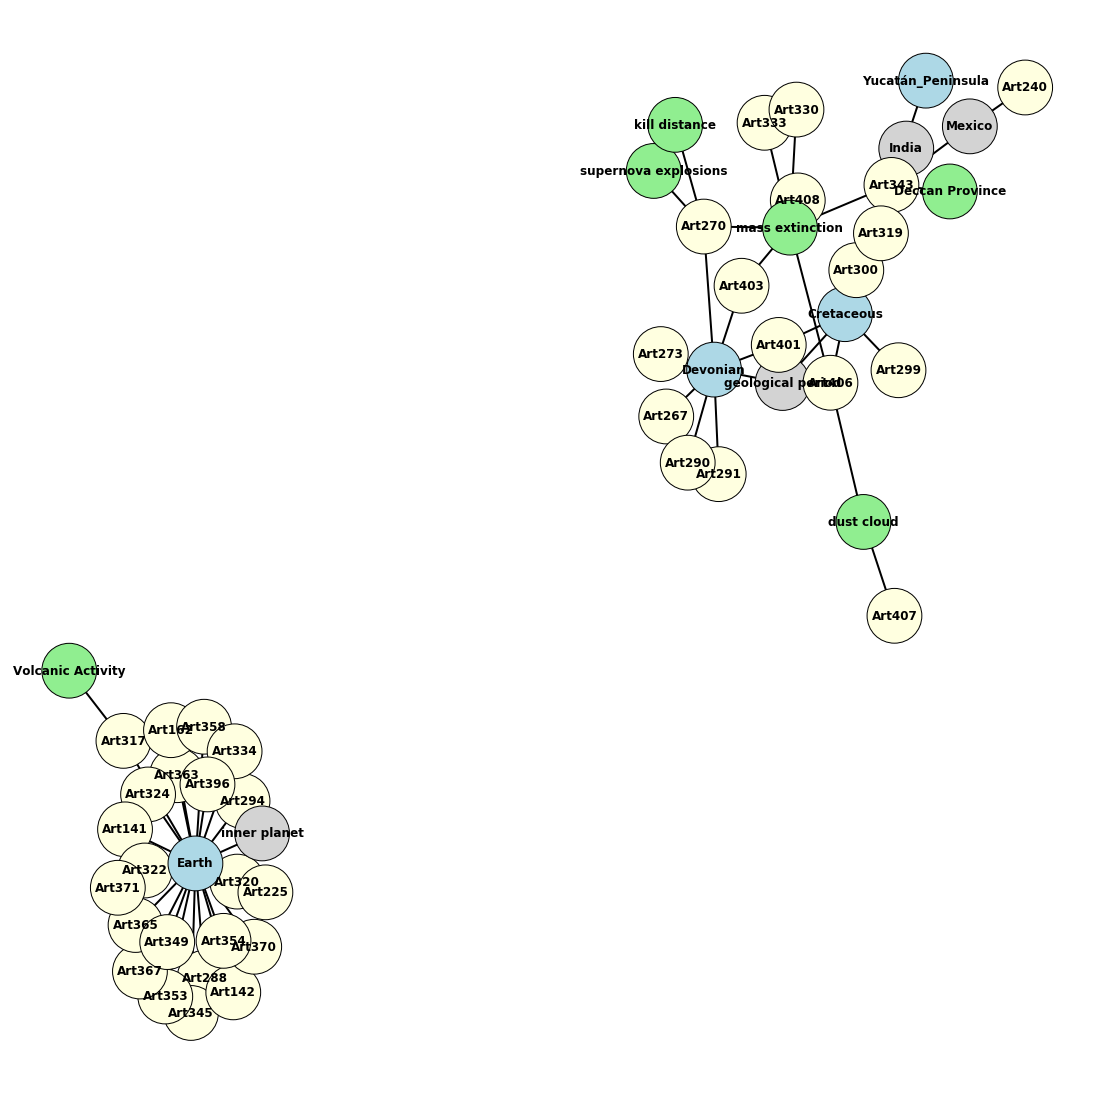

In [114]:
sg = buildMatchingGraph(G,'best-known cause of a mass extinction is an Asteroid '+
                        'impact that killed off the Dinosaurs.')

In [109]:
explainPath(sg,  'supernova explosions', 'Art407')

['supernova explosions', 'Art270', 'mass extinction', 'Art406', 'dust cloud', 'Art407']
----------------
supernova explosions 
----------------
Art270 We therefore propose that the end-Devonian extinctions were triggered by supernova explosions at 20â€‰pc, somewhat beyond the "kill distance" that would have precipitated a full mass extinction.
----------------
mass extinction 
----------------
Art406 It is believed that the Cretaceous mass extinction was caused by meteorites that fell to the earth causing a dust cloud.
----------------
dust cloud 
----------------
Art407 This dust cloud then blocked out the sun, causing atmospheric temperatures to drop and the majority of life on earth to cease.


In [115]:
explainPath(sg,  'Art273', 'Yucatán_Peninsula')

['Art273', 'Devonian', 'Art270', 'mass extinction', 'Art343', 'Yucatán_Peninsula']
----------------
Art273 The Late Devonian biodiversity crisis is characterized by a protracted decline in speciation rate occurring over millions of years (1, 2), punctuated by an extinction pulse (Kellwasser event) followed 10 My later by a more moderate extinction (Hangenberg event) around the Devonian-Carboniferous boundary (DCB) 359 My ago.
----------------
Devonian "fourth period of the Paleozoic Era"
----------------
Art270 We therefore propose that the end-Devonian extinctions were triggered by supernova explosions at 20â€‰pc, somewhat beyond the "kill distance" that would have precipitated a full mass extinction.
----------------
mass extinction 
----------------
Art343 The most likely cause of the Cretaceous mass extinction was an extraterrestrial impact in the Yucatan of modern-day Mexico, a massive volcanic eruption in the Deccan Province of modern-day west-central India, or both in combinatio

s= [[1.0, 189], [0.9134191095796336, 186], [1.0, 210], [0.7950824307145912, 52], [0.7898665348435598, 189]]
5
Art189-- Modern physical cosmology is dominated by the Big Bang theory, which attempts to bring together observational astronomy and particle physics; more specifically, a standard parameterization of the Big Bang with dark matter and dark energy, known as the Lambda-CDM model.
Art186-- Cosmology is a branch of astronomy concerned with the studies of the origin and evolution of the universe, from the Big Bang to today and on into the future.
Art210-- On 1 December 2014, at the Planck 2014 meeting in Ferrara, Italy, astronomers reported that the universe is 13 billion years old and is composed of 5% atomic matter, 26% dark matter and 68% dark energy.
Art52-- As of December 2018, eleven gravitational wave events have been observed that originated from ten merging black holes (along with one binary neutron star merger).
Art189-- Modern physical cosmology is dominated by the Big Ba

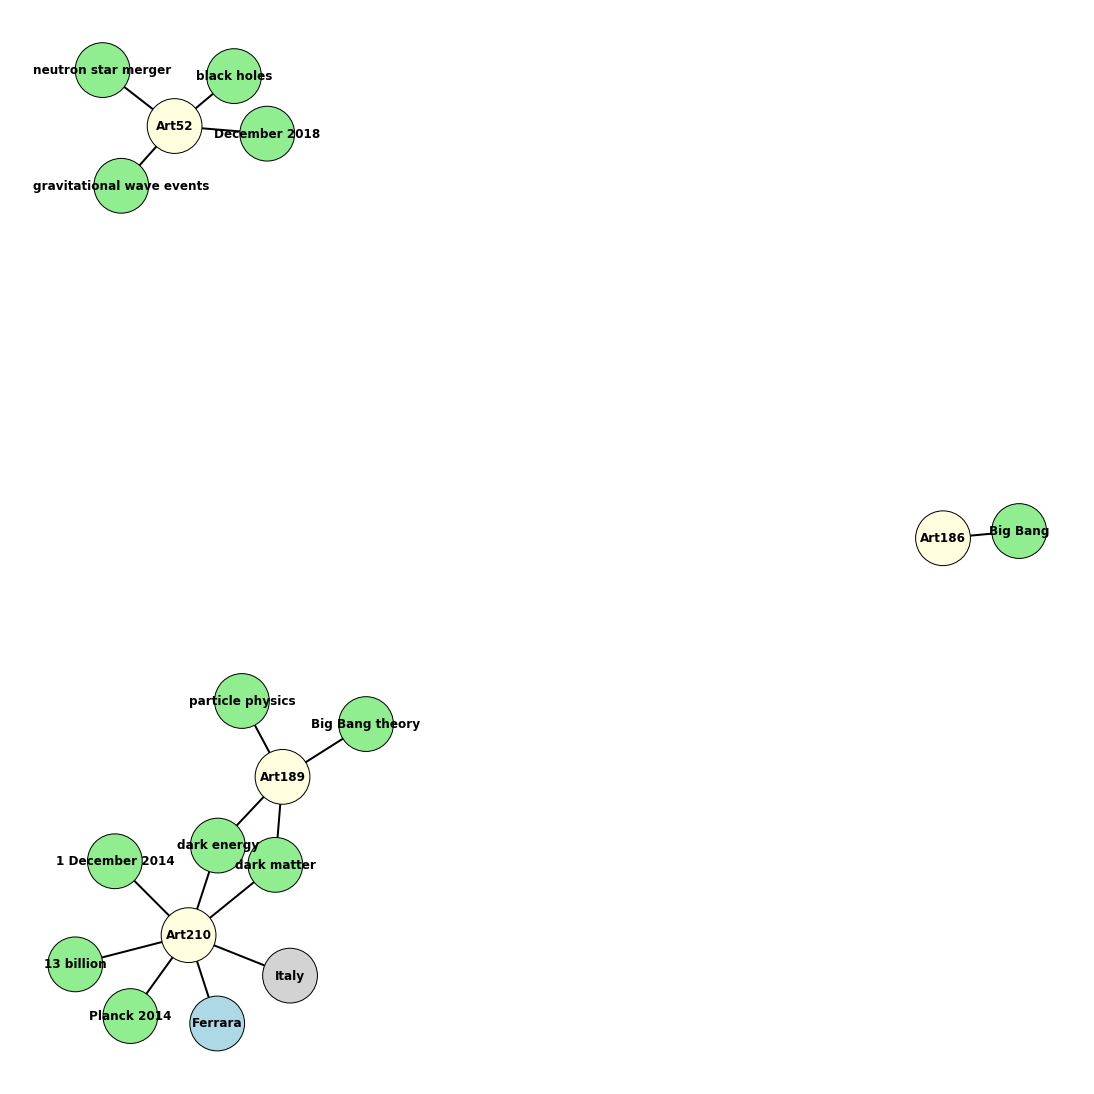

In [104]:
sg =buildMatchingGraph(G,"What is dark energy?", do_closure=False)

let's compute the average number of neighbors a node has.

In [77]:
numarts = len(artlist)
print(numarts)
scor = 0
neighbors = np.zeros(5)
for n in artlist:
    nbrs, _ = findNeighbors(G, n)
    l = len(nbrs)
    if l > 4:
        l = 4
    neighbors[l]+=1
print(neighbors)


427
[140.  57.  37.  26. 167.]


In [75]:
tot = 0
for i in range(5):
    tot += neighbors[i]*i
tot/numarts

2.053864168618267

compute neighbors of neighbors

In [78]:
numarts = len(artlist)
print(numarts)
scor = 0
neighbors = np.zeros(5)
for n in artlist:
    nbrs, _ = findNeighbors(G, n)
    dubnbrs = []
    for x in nbrs:
        if x != n:
            dub, _ = findNeighbors(G, x)
            dubnbrs = dubnbrs + dub
    sdubnbrs = set(dubnbrs)
    nbrs = list(sdubnbrs)
    l = len(nbrs)
    if l > 4:
        l = 4
    neighbors[l]+=1
print(neighbors)


427
[140.  32.  12.   8. 235.]


In [79]:
tot = 0
for i in range(5):
    tot += neighbors[i]*i
tot/numarts

2.388758782201405

In [80]:
140/427

0.32786885245901637

one third of the nodes have no neighbors.  These nodes are not effected by the convolution operation.

now  look at the sizes of the connected components.

In [98]:
comp = nx.connected_components(G)

In [99]:
num_comp = 0
comp_size = np.zeros(7)
for x in comp:
    x_size =  0
    for n in x:
        if G.node[n]['flavor'] == 'article':
            x_size += 1
    if x_size > 6:
        comp_size[6] = x_size
    else:
        comp_size[x_size] += 1
print(comp_size)

[  0.  76.  10.   3.   2.   2. 304.]


In [101]:
total_nodes = 0
for i in range(6):
    total_nodes += comp_size[i]*i
total_nodes + 304

427.0

In [102]:
tot = (76+10*2 +3*3 +4*(2+2+304))/427

In [103]:
tot

3.1311475409836067